### Preparing HDFS
Using magic

Create input folder on HDFS if not exists

Copy from data from local

## Assessment Stage 2: Wrangling

In [1]:
!pwd
! hadoop fs -mkdir -p  /tmp/rs_input
! hadoop fs -put   -p  ./../data-raw/Melbourne_housing_FULL.csv             /tmp/rs_input/raw.csv
! hadoop fs -ls        /tmp/rs_input/

/home/sandpit/big-data-realestate/scripts

put: `/tmp/rs_input/raw.csv': File exists


Found 1 items


-rw-r--r--   1 root root    5018236 2020-05-26 00:56 /tmp/rs_input/raw.csv




 #### Check Spark Parameters

In [2]:
sc.getConf.toDebugString

Intitializing Scala interpreter ...

Spark Web UI available at http://954b276a5616:4040
SparkContext available as 'sc' (version = 2.4.5, master = local[*], app id = local-1591620726302)
SparkSession available as 'spark'


res0: String =
spark.app.id=local-1591620726302
spark.app.name=spylon-kernel
spark.driver.host=954b276a5616
spark.driver.memory=8g
spark.driver.port=44881
spark.executor.id=driver
spark.executor.memory=8g
spark.executor.memoryOverhead=8g
spark.master=local[*]
spark.memory.offHeap.enabled=true
spark.memory.offHeap.size=8g
spark.network.timeout=10000000
spark.rdd.compress=True
spark.repl.class.outputDir=/tmp/tmpvq56usti
spark.repl.class.uri=spark://954b276a5616:44881/classes
spark.serializer.objectStreamReset=100
spark.storage.memoryFraction=0.4
spark.submit.deployMode=client
spark.ui.showConsoleProgress=true


#### Read  file 

In [3]:
//load raw into df
val df_raw = spark
    .read
    .format("csv")
    .option("header", "true")
    .load("hdfs://localhost:9000/tmp/rs_input/raw.csv")


df_raw: org.apache.spark.sql.DataFrame = [Suburb: string, Address: string ... 19 more fields]


In [4]:
df_raw.count()

res1: Long = 34857


#### Load data 

In [5]:
//only select columns we need now
var df_working= df_raw.select("Price",
                          "Method",
                          "Type",
                          "Distance",
                          "Rooms",
                          "Bathroom",
                          "Car",
                          "Landsize",
                          "Lattitude",
                          "Longtitude",    
                          "Suburb",
                          "Address",
                          "Date")


//add meaningful to column names
df_working = df_working.withColumnRenamed("Method","MethodOfSale")
    .withColumnRenamed("Distance","DistanceFromCBD")
    .withColumnRenamed("Type","PropertyType")
    .withColumnRenamed("Lattitude","Latitude")

df_working: org.apache.spark.sql.DataFrame = [Price: string, MethodOfSale: string ... 11 more fields]
df_working: org.apache.spark.sql.DataFrame = [Price: string, MethodOfSale: string ... 11 more fields]


#### Filter out  "#N/A" records

In [6]:
//when profiling there are a number of columns with a "#N/A" which need to be removed
df_working = df_working.filter($"DistanceFromCBD" =!= "#N/A")

df_working: org.apache.spark.sql.DataFrame = [Price: string, MethodOfSale: string ... 11 more fields]


#### Change type of columns "Price", "DistanceFromCBD" & "Landsize" to Double, "Rooms", "Bathroom", "Car" to Int

In [7]:
df_working = df_working.withColumn("Price",col("Price").cast("Double"))
    .withColumn("Rooms",col("Rooms").cast("Int"))
    .withColumn("DistanceFromCBD",col("DistanceFromCBD").cast("Double"))
    .withColumn("Bathroom",col("Bathroom").cast("Int"))
    .withColumn("Car",col("Car").cast("Int"))
    .withColumn("Landsize",col("Landsize").cast("Double"))
    .withColumn("Latitude",col("Latitude").cast("Double"))
    .withColumn("Longtitude",col("Longtitude").cast("Double"))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


#### Make First Letter of Suburb Upper Case

In [8]:
// make first letter of suburb upper case
df_working= df_working.withColumn("Suburb", initcap(col("Suburb")))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


#### Split Address on Street and Suffix

In [9]:
df_working.select("Address").show(10)

+------------------+
|           Address|
+------------------+
|     68 Studley St|
|      85 Turner St|
|   25 Bloomburg St|
|18/659 Victoria St|
|      5 Charles St|
|  40 Federation La|
|       55a Park St|
|      16 Maugie St|
|      53 Turner St|
|      99 Turner St|
+------------------+
only showing top 10 rows



In [10]:
//split address on Street name and Suffix
df_working = df_working.withColumn("StreetName",concat(split(col("Address")," ").getItem(1)
                                   , lit(" "),split(col("Address")," ").getItem(2))).drop("Address")

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


In [11]:
df_working.select("StreetName").show(10)

+-------------+
|   StreetName|
+-------------+
|   Studley St|
|    Turner St|
| Bloomburg St|
|  Victoria St|
|   Charles St|
|Federation La|
|      Park St|
|    Maugie St|
|    Turner St|
|    Turner St|
+-------------+
only showing top 10 rows



#### Make First Letter of Street upper

In [12]:
// make first letter of Street upper case
df_working= df_working.withColumn("StreetName", initcap(col("StreetName")))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


#### Convert Property Type to upper

In [13]:
df_working = df_working.withColumn("PropertyType", upper(col("PropertyType")))


df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


#### Remove Bad Landsize Data

In [14]:
//drop all properties with land area less than 12 sqm 
df_working = df_working.filter(!($"Landsize"<12))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


In [15]:
//drop rows where type = h and landsize < 50 sqm
df_working = df_working.filter(!($"Landsize"<50 && $"PropertyType"===1))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


#### Filter Null Values

In [16]:
val df_not_null = df_working.na.drop()

df_not_null: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


In [17]:
df_not_null.printSchema()

root
 |-- Price: double (nullable = true)
 |-- MethodOfSale: string (nullable = true)
 |-- PropertyType: string (nullable = true)
 |-- DistanceFromCBD: double (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Car: integer (nullable = true)
 |-- Landsize: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longtitude: double (nullable = true)
 |-- Suburb: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- StreetName: string (nullable = true)



#### Write Down Clean Data:

In [18]:
! hadoop fs -mkdir -p /tmp/output

In [19]:
val df_output = df_not_null.coalesce(1)
   .write
   .format("csv")
   .option("header","true")
   .mode("overwrite").option("sep",",")
   .save("hdfs://localhost:9000/tmp/output")

df_output: Unit = ()


#### Save the Clean Data to Disk

In [20]:
! hadoop fs -mkdir -p /tmp/output
! hadoop fs -copyToLocal /tmp/output/\*.csv ./../data-clean/cleanMelbourneData.csv

copyToLocal: `./../data-clean/cleanMelbourneData.csv': File exists




## Assessment Stage 3: Modelling

In [21]:
// use the set wrangled from 
var df_clean = df_not_null

df_clean: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


In [22]:
df_clean.cache()
df_clean.printSchema()
df_clean.count()


root
 |-- Price: double (nullable = true)
 |-- MethodOfSale: string (nullable = true)
 |-- PropertyType: string (nullable = true)
 |-- DistanceFromCBD: double (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Car: integer (nullable = true)
 |-- Landsize: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longtitude: double (nullable = true)
 |-- Suburb: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- StreetName: string (nullable = true)



res5: Long = 15710


### Construct vectors from attributes
#### Transform Sale Date into a numeric value

In [23]:
df_clean = df_clean.withColumn("Date",unix_timestamp($"Date", "dd/mm/yyyy"))

df_clean: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


#### Set StringIndexer for Categorical Variables

In [24]:
import org.apache.spark.ml.feature.{FeatureHasher,StandardScaler,OneHotEncoder,VectorAssembler}
import org.apache.spark.ml.feature.{OneHotEncoderEstimator,StringIndexer,VectorIndexer}
import org.apache.spark.ml.linalg.Vectors

//define string indexers on categorical values
val suburbIndexer = new StringIndexer()
    .setInputCol("Suburb")
    .setOutputCol("SuburbIndex")
    .setHandleInvalid("keep")

val streetNameIndexer = new StringIndexer()
    .setInputCol("StreetName")
    .setOutputCol("StreetNameIndex")
    .setHandleInvalid("keep")

//define string indexers
val propertyTypeIndexer = new StringIndexer()
    .setInputCol("PropertyType")
    .setOutputCol("PropertyTypeIndex")
    .setHandleInvalid("keep")

val methodOfSaleIndexer = new StringIndexer()
    .setInputCol("MethodOfSale")
    .setOutputCol("MethodOfSaleIndex")
    .setHandleInvalid("keep")


//set the categorical names
val categoricalFeatureColumnNames= Array("MethodOfSaleIndex",
            "PropertyTypeIndex",
            "SuburbIndex",
            "StreetNameIndex")

val featureColumnNames= Array("MethodOfSale",
            "PropertyType",
             "Suburb",                 
            "StreetName",
            "DistanceFromCBD",
            "Rooms",
            "Bathroom",
            "Car",
            "Landsize",
            "Latitude",
            "Longtitude",
            "Date"
            )

//define feature hasher for Linear Regressoin
val featureHasher = new FeatureHasher()
    .setInputCols(featureColumnNames)
    .setCategoricalCols(categoricalFeatureColumnNames)
    .setOutputCol("hashedFeatures")


import org.apache.spark.ml.feature.{FeatureHasher, StandardScaler, OneHotEncoder, VectorAssembler}
import org.apache.spark.ml.feature.{OneHotEncoderEstimator, StringIndexer, VectorIndexer}
import org.apache.spark.ml.linalg.Vectors
suburbIndexer: org.apache.spark.ml.feature.StringIndexer = strIdx_c48c7549bf69
streetNameIndexer: org.apache.spark.ml.feature.StringIndexer = strIdx_073d7cacf8f1
propertyTypeIndexer: org.apache.spark.ml.feature.StringIndexer = strIdx_e51b806c4ff6
methodOfSaleIndexer: org.apache.spark.ml.feature.StringIndexer = strIdx_021d16a490f3
categoricalFeatureColumnNames: Array[String] = Array(MethodOfSaleIndex, PropertyTypeIndex, SuburbIndex, StreetNameIndex)
featureColumnNames: Array[String] = Array(MethodOfSale, PropertyType, Suburb, StreetName, DistanceFromCBD, Rooms,...

#### Set OneHotEncoder for Categorical Variables

In [26]:
// one hot encoder
val allEncoder = new OneHotEncoderEstimator()
  .setInputCols(categoricalFeatureColumnNames)
  .setOutputCols(Array("MethodOfSaleCategoryVec1",
                       "PropertyTypeCategoryVec2",
                       "SuburbIndexCategoryVec3",
                       "StreetNameIndexCategoryVec4"))



allEncoder: org.apache.spark.ml.feature.OneHotEncoderEstimator = oneHotEncoder_a9e503fbae54


#### Assemble the columns and column vectors into a single column - "features"

In [27]:
val WithEncodedCategoricalFeatureColumnNames = Array(
                    "DistanceFromCBD", 
                    "Rooms", 
                    "Bathroom",
                    "Car", 
                    "Landsize", 
                    "Latitude", 
                    "Longtitude", 
                    "Date", 
                    "MethodOfSaleCategoryVec1",
                    "PropertyTypeCategoryVec2",
                    "SuburbIndexCategoryVec3",
                    "StreetNameIndexCategoryVec4")

val assembler = new VectorAssembler()
            .setInputCols(WithEncodedCategoricalFeatureColumnNames)
            .setOutputCol("features")


WithEncodedCategoricalFeatureColumnNames: Array[String] = Array(DistanceFromCBD, Rooms, Bathroom, Car, Landsize, Latitude, Longtitude, Date, MethodOfSaleCategoryVec1, PropertyTypeCategoryVec2, SuburbIndexCategoryVec3, StreetNameIndexCategoryVec4)
assembler: org.apache.spark.ml.feature.VectorAssembler = vecAssembler_57bdde14c9fd


#### Set StandardScaler

In [28]:
val scaler = new StandardScaler()
      .setInputCol("features")
      .setOutputCol("scaledFeatures")
      .setWithStd(true).setWithMean(true)


scaler: org.apache.spark.ml.feature.StandardScaler = stdScal_809ad91e0e05


### Apply Log Transform to Price (right skewed --> 'more normal')

In [29]:
df_clean = df_clean.withColumn("loggedPrice", log($"Price").cast("Double"))

df_clean: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 12 more fields]


In [30]:
df_clean.select("loggedPrice").show(4)


+------------------+
|       loggedPrice|
+------------------+
|14.207552645740298|
|13.849911984681606|
|14.197365800433305|
|13.652991628466498|
+------------------+
only showing top 4 rows



In [31]:
//check the antilog - introduces a slight rounding error
//could fix in future
df_clean.withColumn("PriceAntilog", exp((col("loggedPrice")))).select("Price","PriceAntilog").show(10)

+---------+------------------+
|    Price|      PriceAntilog|
+---------+------------------+
|1480000.0|1480000.0000000007|
|1035000.0|1034999.9999999997|
|1465000.0|1465000.0000000005|
| 850000.0| 849999.9999999994|
|1600000.0| 1600000.000000001|
| 941000.0| 940999.9999999994|
|1876000.0|1876000.0000000012|
|1636000.0| 1635999.999999999|
|1097000.0|1096999.9999999995|
|1350000.0|1350000.0000000002|
+---------+------------------+
only showing top 10 rows



### Split Data into a Training and a Testing Set

### Compare raw and clean data by proportion of property type

In [32]:
df_raw.toDF.createOrReplaceTempView("df_py_raw")
df_clean.toDF.createOrReplaceTempView("df_py_clean")

In [33]:
%%python
df_raw_p = spark.sql("select * from df_py_raw")
df_clean_p = spark.sql("select * from df_py_clean")
df_clean_p.show(5)

+---------+------------+------------+---------------+-----+--------+---+--------+--------+----------+----------+----------+-------------+------------------+
|    Price|MethodOfSale|PropertyType|DistanceFromCBD|Rooms|Bathroom|Car|Landsize|Latitude|Longtitude|    Suburb|      Date|   StreetName|       loggedPrice|
+---------+------------+------------+---------------+-----+--------+---+--------+--------+----------+----------+----------+-------------+------------------+
|1480000.0|           S|           H|            2.5|    2|       1|  1|   202.0|-37.7996|  144.9984|Abbotsford|1451779920|    Turner St|14.207552645740298|
|1035000.0|           S|           H|            2.5|    2|       1|  0|   156.0|-37.8079|  144.9934|Abbotsford|1451865720| Bloomburg St|13.849911984681606|
|1465000.0|          SP|           H|            2.5|    3|       2|  0|   134.0|-37.8093|  144.9944|Abbotsford|1483488180|   Charles St|14.197365800433305|
| 850000.0|          PI|           H|            2.5|    3

In [34]:
! pip install matplotlib
! pip install pandas

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')


<IPython.core.display.Javascript object>


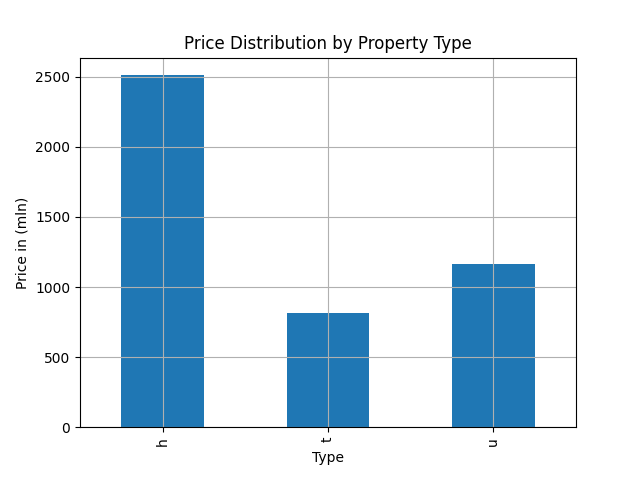

In [35]:
%matplotlib notebook 
%%python

import pandas as pd
import matplotlib.pyplot as plt

df_raw_pd = df_raw_p.toPandas() 
print(df_raw_pd.columns)

ax = df_raw_pd.groupby("Type")["Price"].nunique().plot(kind="bar")
ax.set_ylabel("Price in (mln)")
ax.set_xlabel("Type")
plt.grid()
plt.title("Price Distribution by Property Type")
plt.show()

<IPython.core.display.Javascript object>


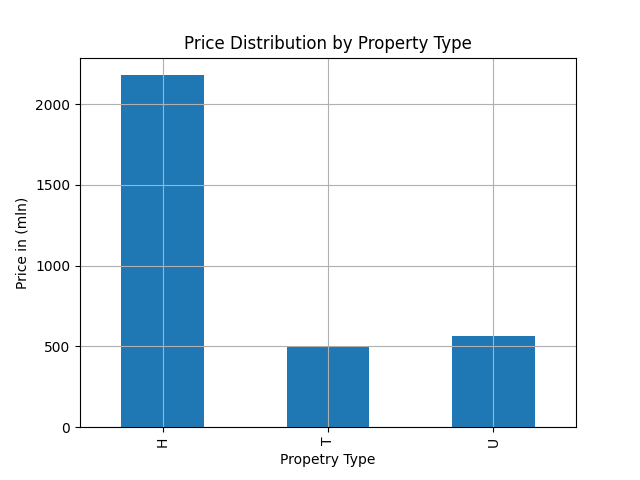

In [36]:
%matplotlib notebook 
%%python

import pandas as pd
import matplotlib.pyplot as plt

df_clean_pd = df_clean_p.toPandas() 

# H -House, T -Townhouse, U- Unit, 
ax = df_clean_pd.groupby("PropertyType")["Price"].nunique().plot(kind="bar")
ax.set_ylabel("Price in (mln)")
ax.set_xlabel("Propetry Type")
plt.grid()
plt.title("Price Distribution by Property Type")
plt.show()

### Split Data into Train/Test Balanced on Property Type in Raw Data

In [37]:
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.functions._

//stratafied sample on propertype type
//original random sample may have been skewing the model
//used proper type as the prices vary wildly based on the type 

//idea is split into training and testing - then stratify the training set so its balanced.
def train_test_split(data: DataFrame, fraction: Double) = {
    
    //split into 80% 20%
    var Array (train, test) = data.randomSplit(Array(0.8, 0.2), seed = 30)
    
    //val sample_data = data.stat.sampleBy("PropertyType",data,36L)
    val train_fractions = Map("H" -> 0.8*fraction,"T" ->0.9*fraction, "U" -> 0.9*fraction)
    val test_fractions = Map("H" -> 0.8*fraction,"T" ->0.9*fraction, "U" -> 0.9*fraction)
    
         
    train = train.stat.sampleBy("PropertyType",train_fractions,36L)
    test = test.stat.sampleBy("PropertyType",test_fractions,36L)
    
     //sample from the data without train set 
     (train, test)
}

import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.functions._
train_test_split: (data: org.apache.spark.sql.DataFrame, fraction: Double)(org.apache.spark.sql.Dataset[org.apache.spark.sql.Row], org.apache.spark.sql.Dataset[org.apache.spark.sql.Row])


In [38]:
//full data set
val (train, test) = train_test_split(df_clean,1)//train_test_split(test_pt,1)
//fraction of data set for finding best model
val (train_sample, test_sample) = train_test_split(df_clean,0.1)//train_test_split(test_pt,0.1)
train.cache()
test.cache()
train_sample.cache()
test_sample.cache()

train: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Price: double, MethodOfSale: string ... 12 more fields]
test: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Price: double, MethodOfSale: string ... 12 more fields]
train_sample: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Price: double, MethodOfSale: string ... 12 more fields]
test_sample: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Price: double, MethodOfSale: string ... 12 more fields]
res10: test_sample.type = [Price: double, MethodOfSale: string ... 12 more fields]


In [39]:
train.count()

res11: Long = 10195


In [40]:
test.count()

res12: Long = 2548


In [41]:
train_sample.count()

res13: Long = 1043


In [42]:
test_sample.count()

res14: Long = 230


### 1. Apply Linear Regression


#### Define Execution Time for LR

In [43]:
//function for getting execution time from start and end times
def getExecutionTime(start: Long , end : Long) = {
    val duration:Long = (end - start)/1000
    duration
}

getExecutionTime: (start: Long, end: Long)Long


#### Run LR Model with Default Params

Assess the training set

In [44]:
train.columns

res15: Array[String] = Array(Price, MethodOfSale, PropertyType, DistanceFromCBD, Rooms, Bathroom, Car, Landsize, Latitude, Longtitude, Suburb, Date, StreetName, loggedPrice)


In [ ]:
import org.apache.spark.ml.regression.LinearRegression
import org.apache.spark.ml.Pipeline
val startTimeMillis = System.currentTimeMillis()

val lr = new LinearRegression()
    .setLabelCol("loggedPrice")
    .setFeaturesCol("scaledFeatures")
    .setPredictionCol("Predicted loggedPrice")
    .setMaxIter(100)

   val pipeline = new Pipeline()
      .setStages(Array(suburbIndexer,
                       streetNameIndexer,
                       propertyTypeIndexer,
                       methodOfSaleIndexer,
                       featureHasher,
                       new StandardScaler()
                      .setInputCol("hashedFeatures")
                      .setOutputCol("scaledFeatures")
                      .setWithStd(true).setWithMean(true),
                      lr))
     
  val result =pipeline.fit(train.drop("Price")).transform(test.drop("Price"))

val endTimeMillis = System.currentTimeMillis()

print("Model was executed "
      + getExecutionTime(startTimeMillis,endTimeMillis)+" s")


2020-06-08 12:54:32,644 WARN  [Executor task launch worker for task 64] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_229_0 in memory! (computed 1901.9 MB so far)
2020-06-08 12:54:32,651 WARN  [Executor task launch worker for task 64] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_229_0 to disk instead.
2020-06-08 12:54:32,658 WARN  [Executor task launch worker for task 65] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_229_1 in memory! (computed 1901.9 MB so far)
2020-06-08 12:54:32,659 WARN  [Executor task launch worker for task 65] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_229_1 to disk instead.
2020-06-08 12:54:43,061 WARN  [Executor task launch worker for task 65] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_229_1 in memory! (computed 2.8 GB so far)
2020-06-08 12:55:09,931 WARN  [Executor task launch worker for tas

2020-06-08 13:03:23,418 WARN  [Executor task launch worker for task 100] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_229_0 in memory! (computed 1901.9 MB so far)
2020-06-08 13:03:23,426 WARN  [Executor task launch worker for task 101] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_229_1 in memory! (computed 1901.9 MB so far)
2020-06-08 13:03:49,676 WARN  [Executor task launch worker for task 103] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_229_1 in memory! (computed 1901.9 MB so far)
2020-06-08 13:03:49,693 WARN  [Executor task launch worker for task 102] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_229_0 in memory! (computed 1901.9 MB so far)
2020-06-08 13:04:19,563 WARN  [Executor task launch worker for task 105] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_229_1 in memory! (computed 1901.9 MB so far)


In [ ]:
result.columns

#### Define LR Evaluator

In [ ]:
import org.apache.spark.ml.evaluation.RegressionEvaluator

// define an evaluator 
def evaluate_lr ( predictions: DataFrame, metric: String) = {
    val eval =  new RegressionEvaluator()
       .setLabelCol("loggedPrice")
       .setPredictionCol("Predicted loggedPrice")
       .setMetricName(metric)
println("Root Mean Squared Error "+  metric.toUpperCase()
        +" on test data = " + eval.evaluate(predictions))
}


#### Regression Metrics

**Mean squared error (MSE)** -- the average of squared differences between the predicted outcome and the true outcome.

**R2 coefficient** -- the proportion of variance in the outcome that our model is capable of predicting based on its features.


In [ ]:
evaluate_lr(result,"rmse")

In [ ]:
evaluate_lr(result,"r2")

####  Finding the Best Model (Parameter Tuning) by Cross-Validation


In [ ]:
train_sample.columns

In [ ]:
import org.apache.spark.ml.param.ParamMap
import org.apache.spark.ml.tuning.{CrossValidator, ParamGridBuilder}


//Creates a crossvalidator on only the LR model
//Had some issues retreiving the params when using on pipeline
//and the pipeline only has one estimator in it so this was easier than traversing the stages of the pipline

val startTimeMillis = System.currentTimeMillis()

//set LR with 100 max iter
val lr = new LinearRegression()
    .setLabelCol("loggedPrice")
    .setFeaturesCol("scaledFeatures")
    .setPredictionCol("Predicted LoggedPrice")


val pipeline = new Pipeline()
    .setStages(Array(suburbIndexer,
                    streetNameIndexer,
                    propertyTypeIndexer,
                    methodOfSaleIndexer,
                    featureHasher,
                    new StandardScaler()
                    .setInputCol("hashedFeatures")
                    .setOutputCol("scaledFeatures")
                    .setWithStd(true).setWithMean(true),
                    lr))
     
// We use a ParamGridBuilder to construct a grid of parameters to search over.
val paramGrid = new ParamGridBuilder()
  .addGrid(lr.regParam, Array(0,0.1,0.5,1))
  .addGrid(lr.elasticNetParam, Array(0,0.1,0.5,1))
  .build()

// We now treat the model as an Estimator, wrapping it in a CrossValidator instance.
// This will allow us to choose best params for the model
val cv = new CrossValidator()
  .setEstimator(pipeline)
  .setEvaluator(new RegressionEvaluator()
  .setLabelCol("loggedPrice")
  .setPredictionCol("Predicted LoggedPrice")
  .setMetricName("rmse"))
  .setEstimatorParamMaps(paramGrid)
  .setNumFolds(5)  
  .setParallelism(2)


// Run cross-validation, and choose the best set of parameters.
val cvModel = cv.fit(train_sample.drop("Price"))

// Make predictions on test documents. 
//cvModel uses the best model found.
cvModel.transform(test_sample.drop("Price"))
  .select("loggedPrice", "Predicted LoggedPrice")
  .show()

//print runtime
val endTimeMillis = System.currentTimeMillis()

print("Model was executed "
      + getExecutionTime(startTimeMillis,endTimeMillis)+" s")

In [ ]:
cvModel.bestModel

#### Extracting the Best Model

In [ ]:
import org.apache.spark.ml.PipelineModel
import org.apache.spark.ml.regression.LinearRegressionModel

//print out the params used for the best model
val bestModel = cvModel.bestModel
val bestLRModel = bestModel.asInstanceOf[PipelineModel].stages.last.asInstanceOf[LinearRegressionModel]
println("params = " + bestLRModel.extractParamMap())

#### Define LR Pipeline for the Best Model

In [ ]:
val lr_best = new LinearRegression()
  .setLabelCol("loggedPrice")
  .setPredictionCol("Predicted LoggedPrice")
  .setFeaturesCol("scaledFeatures")
  .setRegParam(bestLRModel.getRegParam)
  .setMaxIter(bestLRModel.getMaxIter)



val lrStages = Array(suburbIndexer,
                    streetNameIndexer,
                    propertyTypeIndexer,
                    methodOfSaleIndexer,
                    featureHasher,
                    new StandardScaler()
                    .setInputCol("hashedFeatures")
                    .setOutputCol("scaledFeatures")
                    .setWithStd(true).setWithMean(true),
                    lr_best
)

In [ ]:
val startTimeMillis = System.currentTimeMillis()

//define a pipleine
val lrPipe = new Pipeline().setStages(lrStages)

// We fit our DataFrame into the pipeline to generate a model
// pass best ParamMap from cross validation
val lrModel = lrPipe.fit(train)


// Make predictions using the model and the test data
// pass best ParamMap from cross validation
val predictions = lrModel.transform(test)

val endTimeMillis = System.currentTimeMillis()

print("Pipeline was executed "
      + getExecutionTime(startTimeMillis,endTimeMillis))


In [ ]:
predictions.columns

#### Undo the Log Transformn on the Prediciton


In [ ]:
var logtransformPredict = predictions.withColumn("Predicted loggedPrice",col("Predicted loggedPrice").cast("Double"))

logtransformPredict.withColumn("Predicted Price", exp((col("Predicted loggedPrice")))).select("Predicted Price").show(5)


In [ ]:
//inverse the log transform
val bestlr_predict = logtransformPredict.withColumn("Predicted Price", exp((col("Predicted loggedPrice"))))

#### Predictions on the Best Model

In [ ]:
//finesse the output of predicted price and price to aid visual compare
bestlr_predict.withColumn("Predicted Price", round($"Predicted Price", 0))
    .select("Price","Predicted Price").show()

#### Regression Metrics


In [ ]:
evaluate_lr(bestlr_predict,"rmse")

In [ ]:
evaluate_lr(bestlr_predict,"r2")

### 2. Apply Random Forest Regression

**Build Random Forest model**

Specify _numTrees, maxDepth, maxBins, featureSubsetStrategy_ and _seed_ parameters.

* **numTrees** -- Number of trees in the forest

* **maxDepth** -- Maximum depth of a tree. Increasing the depth makes the model more powerful, but deep trees take longer to train.

* **maxBins** -- Maximum number of bins used for discretizing continuous features and for choosing how to split on features at each node.

* **featureSubsetStrategy** -- Automatically select the number of features to consider for splits at each tree node

* **seed** -- Use a random seed number , allowing to repeat the results
* **MaxMemoryInMB** - Maximum memory in MB allocated to histogram aggregation.
* **CacheNodeIds** - If FALSE, the algorithm will pass trees to executors to match instances with nodes. If TRUE, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.


If the number of trees is 1, then no bootstrapping is used at all. However, if the number of trees is > 1, then the bootstrapping is accomplished. Where, the parameter _featureSubsetStrategy_ signifies the number of features to be considered for splits at each node. The supported values of _featureSubsetStrategy_ are "auto", "all", "sqrt", "log2" and "on third". The supported numerical values, on the other hand, are $(0.0-1.0]$ and $[1-n]$. However, if _featureSubsetStrategy_ is chosen as $"auto"$, the algorithm chooses the best feature subset strategy automatically


If the $numTrees == 1$, the featureSubsetStrategy is set to be "all". However, if the $numTrees > 1$ (i.e., forest), featureSubsetStrategy is set to be "onethird" for regression


Moreover, if a real value "n" is in the range $(0, 1.0]$ is set, n*number_of_features is used consequently. However, if an integer value "n" is in the range (1, the number of features) is set, only n features are used alternatively


The parameter _categoricalFeaturesInfo_ which is a map is used for storing arbitrary of categorical features. An entry $(n -> k)$ indicates that feature n is categorical with k categories indexed from $0: {0, 1,...,k-1}$
The impurity criterion used for regression is “variance”. 

The _maxDepth_ is the maximum depth of the tree. (e.g., depth 0 means 1 leaf node, depth 1 means 1 internal node + 2 leaf nodes). However, the suggested value is 4 to get a better result


The _maxBins_ signifies the maximum number of bins used for splitting the features; where the suggested value is 100 to get better results


Finally, the random seed is used for bootstrapping and choosing feature subsets to avoid the random nature of the results.

#### Define time Function

In [ ]:
def time[R](block: => R): R = {
  val t0 = System.nanoTime()
  val result = block    // call-by-name
  val t1 = System.nanoTime()
  println("Elapsed time: " + (t1 - t0)/1000000000 + " s")
  result
 }

In [ ]:
import org.apache.spark.ml.regression.RandomForestRegressor

val rf = new RandomForestRegressor()
  .setSeed(36L)
  .setLabelCol("Price")
  .setFeaturesCol("scaledFeatures")
  .setPredictionCol("prediction")
  .setMaxMemoryInMB(512)
  .setCacheNodeIds(true)

rf.extractParamMap()

In [ ]:
test.columns

In [ ]:
train.columns

#### Define get_predictions Function

In [ ]:
import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel
import org.apache.spark.ml.Pipeline

def get_predictions[R <: Predictor[Vector, R, M],
                M <: PredictionModel[Vector, M]](
    predictor: Predictor[Vector, R, M],
    train: DataFrame, 
    test: DataFrame) = {
    
    val pipeline = new Pipeline()
      .setStages(Array(suburbIndexer,
                       streetNameIndexer,
                       propertyTypeIndexer,
                       methodOfSaleIndexer,
                       allEncoder,
                       assembler, 
                       scaler,
                       predictor))
     
    val result =pipeline.fit(train).transform(test)
    result

}

In [ ]:
val rfPredictions = time{get_predictions(rf, train, test)}
rfPredictions.cache()

In [ ]:
rfPredictions.withColumn("prediction", round($"prediction", 0)).select("Price","prediction").show(5)

In [ ]:
rfPredictions.describe().select("summary","Price","prediction").show()

#### Regression Metrics


In [ ]:

def assess_rf ( predictions: DataFrame, metric: String) = {
    val eval =  new RegressionEvaluator()
       .setLabelCol("Price")
       .setPredictionCol("prediction")
       .setMetricName(metric)
println(metric.toUpperCase()+" on test data = " + eval.evaluate(predictions))
    
}

In [ ]:
assess_rf(rfPredictions,"rmse")

In [ ]:
assess_rf(rfPredictions,"r2")

####  Finding the Best Model (Parameter Tuning) by Cross-Validation


In [ ]:
import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel



def train_eval[R <: Predictor[Vector, R, M],
               M <: PredictionModel[Vector, M]](
    predictor: Predictor[Vector, R, M],
    paramMap: Array[ParamMap],
    train: DataFrame, 
    test: DataFrame) = {

    val pipeline = new Pipeline()
      .setStages(Array(
          suburbIndexer,
          streetNameIndexer,
          propertyTypeIndexer,
          methodOfSaleIndexer,
          allEncoder,
          assembler, 
          scaler,
          predictor))
    
    val cv = new CrossValidator()
        .setEstimator(pipeline)
        .setEvaluator(new RegressionEvaluator()
        .setLabelCol("Price")
        .setPredictionCol("prediction")
        .setMetricName("rmse"))
        .setEstimatorParamMaps(paramMap)
        .setNumFolds(5)
        .setParallelism(2)

    val cvModel = cv.fit(train)
    val predictions = cvModel.transform(test)
    
    predictions.cache()
   
    val bestModel = cvModel.bestModel
    
    println(bestModel.extractParamMap)
    
    bestModel
}


In [ ]:
import org.apache.spark.ml.regression.RandomForestRegressor

// Models hyperparameters
val numTrees = Seq(5,10,20,30,50,100)
val maxBins = Seq(32,50,100)
val maxDepth = Seq(2,3,5)
//val featureSubsetStrategy = Seq("sqrt","onethird")

val rf = new RandomForestRegressor()
  .setSeed(36L)
  .setLabelCol("Price")
  .setFeaturesCol("scaledFeatures")
  .setPredictionCol("prediction")
  .setImpurity("variance")
  .setMaxMemoryInMB(512)
  .setCacheNodeIds(true)


val rfParamMap = new ParamGridBuilder()
  .addGrid(rf.numTrees, numTrees)
  .addGrid(rf.maxDepth, maxDepth)
  .addGrid(rf.maxBins, maxBins)
  .build()

val tStart = System.nanoTime()
val best_model = train_eval(rf, rfParamMap, train, test)
val tEnd = System.nanoTime()

print("Model was executed "
      + getExecutionTime(tStart/1000000,tEnd/1000000)+" s")

### Extracting the Best Model

In [ ]:

import org.apache.spark.ml.regression.RandomForestRegressionModel

val bestPipelineModel = best_model.asInstanceOf[PipelineModel]

val stages = bestPipelineModel.stages
for (i <- stages) println

val bestRFModel = stages.last.asInstanceOf[RandomForestRegressionModel]

println("RF params = " + bestRFModel.extractParamMap())


#### Prediction on the Best Model

In [ ]:
val seed = 5043
val rf_best = new RandomForestRegressor()
  .setSeed(seed)
  .setLabelCol("Price")
  .setNumTrees(bestRFModel.getNumTrees)
  .setMaxDepth(bestRFModel.getMaxDepth)
  .setMaxBins(bestRFModel.getMaxBins)
  .setMaxMemoryInMB(512)
  .setCacheNodeIds(true)

val rf_best_Predictions = time{get_predictions(rf_best, train, test)}
rfPredictions.cache()

#### Regression Metrics on the Best Model


In [ ]:
assess_rf(rf_best_Predictions,"rmse")

In [ ]:
assess_rf(rf_best_Predictions,"r2")

### 3. Apply K-means Model  

Unsupervised learning problem. To find opimal number of clusters run many models with differnet numer of clusters. When the number of clusters increses the differences between clusters gets smaller while the differences between points inside clusters increase as well. Optimally, WCSSE -  Within Set Sum of Squared Errors, should be as small as possible, while Slhouette coefficient [-1,1] cohesion and separation should get as close to 1 as possible.

* WSSSE -  Within Set Sum of Squared Errors
* Slhouette coefficient  for a data point is  $(b-a)/max(a,b)$, where $a$ - measure of cohesion (mean intra-cluster distance), b - measure of separarion (the distance between a sample and the nearest cluster that the sample is not a part of)


#### Training and Predicting


In [ ]:
import org.apache.spark.ml.clustering.{KMeans,KMeansModel}

val kmeans = new KMeans().setSeed(5043L)
                         .setPredictionCol("cluster")
                         .setFeaturesCol("scaledFeatures")


In [ ]:
import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel
import org.apache.spark.ml.Pipeline
import org.apache.spark.ml.clustering.KMeansModel


val pipeline = new Pipeline()
      .setStages(Array(suburbIndexer,
                       streetNameIndexer,
                       propertyTypeIndexer,
                       methodOfSaleIndexer,
                       featureHasher,
                       new StandardScaler()
                      .setInputCol("hashedFeatures")
                      .setOutputCol("scaledFeatures")
                      .setWithStd(true).setWithMean(true),
                       kmeans))
     
val tStart = System.currentTimeMillis()
 
val kmeansPipeModel =pipeline.fit(train)

val kmeansPredictions =kmeansPipeModel.transform(test)

val tEnd = System.currentTimeMillis()

kmeansPredictions.cache()
print("Model was executed "
      + getExecutionTime(tStart/1000,tEnd/1000)+" s")



In [ ]:
kmeansPredictions.columns

In [ ]:
val kmeansModel =kmeansPipeModel.stages.last.asInstanceOf[KMeansModel]

In [ ]:
for (i <- Array.range(0, kmeansModel.getK.toInt)){
  println("Cluster "+i+":")
  kmeansPredictions.where($"cluster" === i).describe().select("Summary", "Price").show()
}   

#### Evaluation.

The silhouette metrics ranges between -1 and 1, where a value close to 1 means that the points in a cluster are close to the other points in the same cluster and far from the points of the other clusters.

In [ ]:
import org.apache.spark.ml.evaluation.ClusteringEvaluator

def assess_kmeans( predictions: DataFrame, metric: String) = {
    val eval =  new ClusteringEvaluator()
       .setPredictionCol("cluster")
       .setMetricName(metric)
println(metric.toUpperCase()+" on test data = " + eval.evaluate(predictions))
    
}

In [ ]:
assess_kmeans(kmeansPredictions,"silhouette")

In [ ]:
val WSSSE = kmeansModel.computeCost(kmeansPredictions)
println(s"WSSSE error = $WSSSE")

In [ ]:
val scaled_WSSSE = WSSSE/test.count()

print(s"Normalised WCSSE error = ")
println("%06.2f".format(scaled_WSSSE))

#### Prediction on the Best Model

In [ ]:
import org.apache.spark.ml.evaluation.ClusteringEvaluator
import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel

def eval_points(maxK: Int): Map[Int, Double] = {
  val evaluator = new ClusteringEvaluator()
       .setFeaturesCol("scaledFeatures")
       .setPredictionCol("Predicted LoggedPrice")
       .setMetricName("silhouette")
    val kmeans = new KMeans().setSeed(5043L).setK(maxK)
    val pipeline = new Pipeline()
      .setStages(Array(suburbIndexer,
                       streetNameIndexer,
                       propertyTypeIndexer,
                       methodOfSaleIndexer,
                       allEncoder,
                       assembler, 
                       scaler,
                       kmeans))
    
  var points = Map(2 -> WSSSE)
  for (i <- Array.range(3, maxK)){

    
    val kmeansPipeModel = pipeline.fit(train_sample)
    val kmeansPredictions = kmeansPipeModel.transform(test_sample)
    val silhouette = evaluator.evaluate(predictions)
    points += (i -> silhouette)
  }
  points
}

In [ ]:
val points = time{eval_points(20)}

In [ ]:
val (best_num_centroids, silhouette) = points.toArray.sortWith(_._2 < _._2)(0)
best_num_centroids
best_wssse/num_sample

In [ ]:
#### Clustering around predicted centroids

In [ ]:
import org.apache.spark.ml.clustering.{KMeans,KMeansModel}

val best_kmeans = new KMeans().setSeed(5043L)
                         .setPredictionCol("cluster")
                         .setFeaturesCol("scaledFeatures")
                         .setK(best_num_centroids)



In [ ]:
val bestKMPipeline = new Pipeline()
      .setStages(Array(suburbIndexer,
                       streetNameIndexer,
                       propertyTypeIndexer,
                       methodOfSaleIndexer,
                       featureHasher,
                       new StandardScaler()
                      .setInputCol("hashedFeatures")
                      .setOutputCol("scaledFeatures")
                      .setWithStd(true).setWithMean(true),
                       kmeans))
     
val tStart = System.currentTimeMillis()
 
val bestMeansPipeModel =bestKMPipeline.fit(train)

val bestKmeansPredictions =bestMeansPipeModel.transform(test)

val tEnd = System.currentTimeMillis()

bestKmeansPredictions.cache()
print("Model was executed "
      + getExecutionTime(tStart/1000,tEnd/1000)+" s")




In [ ]:
for (i <- Array.range(0, kmeansModel.getK.toIntbest_num_centroids)){
  println("Cluster "+i+":")
  bestKmeansPredictions.where($"cluster" === i).describe().select("Summary", "Price").show()
}   

### References

Apache Spark (n.d.). _Spark ML Programming Guide._ Retrieved from https://spark.apache.org/docs/1.2.2/ml-guide.html

Bahadoor N., (2020). _Spark tutorials_ Retrieved from https://allaboutscala.com/big-data/spark/
Gorczynski M. (2017). _Introduction to machine learning with spark and mllib (dataframe API)._ Retrieved from https://scalac.io/scala-spark-ml-machine-learning-introduction/

Hydrospheredata (2020). Program creek. Scala Code Examples. Scaler Retrieved from https://www.programcreek.com/scala/org.apache.spark.ml.feature.StandardScaler

Jen G. (2020) _FeatureHasher_. Retrieved from https://george-jen.gitbook.io/data-science-and-apache-spark/featurehasher

Johnson S (2019). _From sckit-learn to Spark ML._ Retrieved from https://towardsdatascience.com/from-scikit-learn-to-spark-ml-f2886fb46852

Johnson S (2019). _Housing Prices - Spark ML Project_ Retrieved from https://github.com/scottdjohnson/HousingPricePredictions/blob/master/HousingPrices-SparkML.ipynb

Masri A. (2019). _FeatureTransformation. Retrieved from
https://towardsdatascience.com/apache-spark-mllib-tutorial-7aba8a1dce6e

Poddutur S. (). _Distribution of Executors, Cores and Memory for a Spark Application running in Yarn:_ Retrieved from https://spoddutur.github.io/spark-notes/distribution_of_executors_cores_and_memory_for_spark_application.html 

Rai D.,(2018) _Feature Engineering in pyspark — Part I._ Retrieved from https://medium.com/@dhiraj.p.rai/essentials-of-feature-engineering-in-pyspark-part-i-76a57680a85

Sarkar A. (2017). _Learning Spark SQL. Implementing a Spark ML clustering model._ Packt Publishing.

Scala Doc (n.d.) Retrieved from https://docs.scala-lang.org


(2019) _Random Forest Classifier with Apache Spark_ Retireved from https://medium.com/rahasak/random-forest-classifier-with-apache-spark-c63b4a23a7cc

Wagle M.(2020) _Predicting House Prices using Machine Learning_. Retrieved from https://medium.com/@manilwagle/predicting-house-prices-using-machine-learning-cab0b82cd3f


Zecevic P., Bonaci M. (2020) _Spark in Action_ Retireved from https://livebook.manning.com/book/spark-in-action/about-this-book/